In [53]:
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import argparse
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from torch.optim.lr_scheduler import _LRScheduler
import random

### Randomness 제어

In [54]:
seed = 2021

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [55]:
file_name = "dataset1.csv"
df = pd.read_csv(file_name)
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('지점명', axis=1)
df.head(2)

,년,5월평균기온,5월합강수량(mm),5월합계일조시간,6월평균기온,6월합강수량(mm),6월합계일조시간,7월평균기온,7월합강수량(mm),7월합계일조시간,8월평균기온,8월합강수량(mm),8월합계일조시간,단위면적당 생산량
0,1996,14.2,20.2,151.1,18.0,356.5,107.6,22.0,189.4,128.3,23.0,200.0,135.8,438.0
1,1997,16.2,355.6,135.0,19.8,113.0,110.7,24.2,73.3,218.3,24.7,60.3,170.5,451.0


### 지점명을 integer로 바꾸기

In [56]:
le = LabelEncoder()
# df['지점명'] = le.fit_transform(df['지점명'])
df.head(2)

# 지점명 복원은 le.inverse_transform 으로 가능

,년,5월평균기온,5월합강수량(mm),5월합계일조시간,6월평균기온,6월합강수량(mm),6월합계일조시간,7월평균기온,7월합강수량(mm),7월합계일조시간,8월평균기온,8월합강수량(mm),8월합계일조시간,단위면적당 생산량
0,1996,14.2,20.2,151.1,18.0,356.5,107.6,22.0,189.4,128.3,23.0,200.0,135.8,438.0
1,1997,16.2,355.6,135.0,19.8,113.0,110.7,24.2,73.3,218.3,24.7,60.3,170.5,451.0


### 결측값 처리
결측값이 있는 행은 그냥 지워버렸음. 다른 방식으로 처리 가능하니 상의해볼것

In [57]:
miss_row = df[df.isna().any(axis=1)]
print(miss_row.size)
miss_row.head(2)

490


,년,5월평균기온,5월합강수량(mm),5월합계일조시간,6월평균기온,6월합강수량(mm),6월합계일조시간,7월평균기온,7월합강수량(mm),7월합계일조시간,8월평균기온,8월합강수량(mm),8월합계일조시간,단위면적당 생산량
790,2000,16.1,29.2,215.0,21.4,203.9,158.2,25.7,162.9,197.7,NaN,NaN,10.7,505.0000
896,2023,18.3,174.2,191.4,22.3,33.6,202.7,NaN,377.0,72.3,26.7,164.3,232.0,537.8724


In [58]:
df = df.dropna(axis=0)

In [59]:
X = df.loc[:, df.columns != '단위면적당 생산량']
y = df.loc[:, '단위면적당 생산량']

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,shuffle=True)
X_train = X_train.values
X_val = X_val.values
y_train = y_train.values 
y_val = y_val.values

### 파라미터 관리

In [60]:
parser = argparse.ArgumentParser()
args = parser.parse_args('')

In [61]:
args.epoch = 1000
args.lr = 0.01
args.in_dim = X_train.shape[-1]

In [62]:
class Net(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.f1 = nn.Linear(args.in_dim, 128)
        self.f2 = nn.Linear(128, 1)
        # self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.f1(x))
        # x = self.dropout(x)
        return self.f2(x)

In [63]:
net = Net(args)
net

Net(
  (f1): Linear(in_features=13, out_features=128, bias=True)
  (f2): Linear(in_features=128, out_features=1, bias=True)
)

In [64]:
# 코드 출처 : https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup/blob/master/cosine_annealing_warmup/scheduler.py
class CosineAnnealingWarmupRestarts(_LRScheduler):
    """
        optimizer (Optimizer): Wrapped optimizer.
        first_cycle_steps (int): First cycle step size.
        cycle_mult(float): Cycle steps magnification. Default: -1.
        max_lr(float): First cycle's max learning rate. Default: 0.1.
        min_lr(float): Min learning rate. Default: 0.001.
        warmup_steps(int): Linear warmup step size. Default: 0.
        gamma(float): Decrease rate of max learning rate by cycle. Default: 1.
        last_epoch (int): The index of last epoch. Default: -1.
    """
    
    def __init__(self,
                 optimizer : torch.optim.Optimizer,
                 first_cycle_steps : int,
                 cycle_mult : float = 1.,
                 max_lr : float = 0.1,
                 min_lr : float = 0.001,
                 warmup_steps : int = 0,
                 gamma : float = 1.,
                 last_epoch : int = -1
        ):
        assert warmup_steps < first_cycle_steps
        
        self.first_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle_mult = cycle_mult # cycle steps magnification
        self.base_max_lr = max_lr # first max learning rate
        self.max_lr = max_lr # max learning rate in the current cycle
        self.min_lr = min_lr # min learning rate
        self.warmup_steps = warmup_steps # warmup step size
        self.gamma = gamma # decrease rate of max learning rate by cycle
        
        self.cur_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle = 0 # cycle count
        self.step_in_cycle = last_epoch # step size of the current cycle
        
        super(CosineAnnealingWarmupRestarts, self).__init__(optimizer, last_epoch)
        
        # set learning rate min_lr
        self.init_lr()
    
    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)
    
    def get_lr(self):
        if self.step_in_cycle == -1:
            return self.base_lrs
        elif self.step_in_cycle < self.warmup_steps:
            return [(self.max_lr - base_lr)*self.step_in_cycle / self.warmup_steps + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.max_lr - base_lr) \
                    * (1 + math.cos(math.pi * (self.step_in_cycle-self.warmup_steps) \
                                    / (self.cur_cycle_steps - self.warmup_steps))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.step_in_cycle = self.step_in_cycle + 1
            if self.step_in_cycle >= self.cur_cycle_steps:
                self.cycle += 1
                self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
                self.cur_cycle_steps = int((self.cur_cycle_steps - self.warmup_steps) * self.cycle_mult) + self.warmup_steps
        else:
            if epoch >= self.first_cycle_steps:
                if self.cycle_mult == 1.:
                    self.step_in_cycle = epoch % self.first_cycle_steps
                    self.cycle = epoch // self.first_cycle_steps
                else:
                    n = int(math.log((epoch / self.first_cycle_steps * (self.cycle_mult - 1) + 1), self.cycle_mult))
                    self.cycle = n
                    self.step_in_cycle = epoch - int(self.first_cycle_steps * (self.cycle_mult ** n - 1) / (self.cycle_mult - 1))
                    self.cur_cycle_steps = self.first_cycle_steps * self.cycle_mult ** (n)
            else:
                self.cur_cycle_steps = self.first_cycle_steps
                self.step_in_cycle = epoch
                
        self.max_lr = self.base_max_lr * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [65]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, nesterov=True)
scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=100, gamma=0.9)

## dataloader

In [66]:
class Custom_Dataset():
    def __init__(self, x, y):
        self.x = torch.tensor(x).float()
        self.y = torch.tensor(y).float()
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, ind):
        return self.x[ind], self.y[ind]

In [67]:
train_dataset = Custom_Dataset(X_train, y_train)
val_dataset = Custom_Dataset(X_val, y_val)
train_loader = DataLoader(train_dataset, len(train_dataset), shuffle=True)
val_loader = DataLoader(val_dataset, len(val_dataset), shuffle=False)

## train & validate

In [68]:
list_epoch = []
list_train_loss = []
list_val_loss = []
list_lr = []

for epoch in tqdm(range(1, args.epoch+1)):
    # train
    net.train()
    total_train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        output = net(inputs)
        loss = criterion(output.squeeze(), labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    average_train_loss = total_train_loss / (len(train_loader))
    scheduler.step()

    # validation
    net.eval()
    total_val_loss = 0
    for inputs, labels in val_loader:
        with torch.no_grad():
            output = net(inputs)
            total_val_loss += criterion(output.squeeze(), labels).item()
    
    average_val_loss = total_val_loss / (len(val_loader))
    
    # plot을 위한 데이터 저장
    list_epoch.append(epoch)
    list_train_loss.append(average_train_loss)
    list_val_loss.append(average_val_loss)
    list_lr.append(scheduler.get_lr())

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:29<00:00, 33.48it/s]


### plot 찍어보기

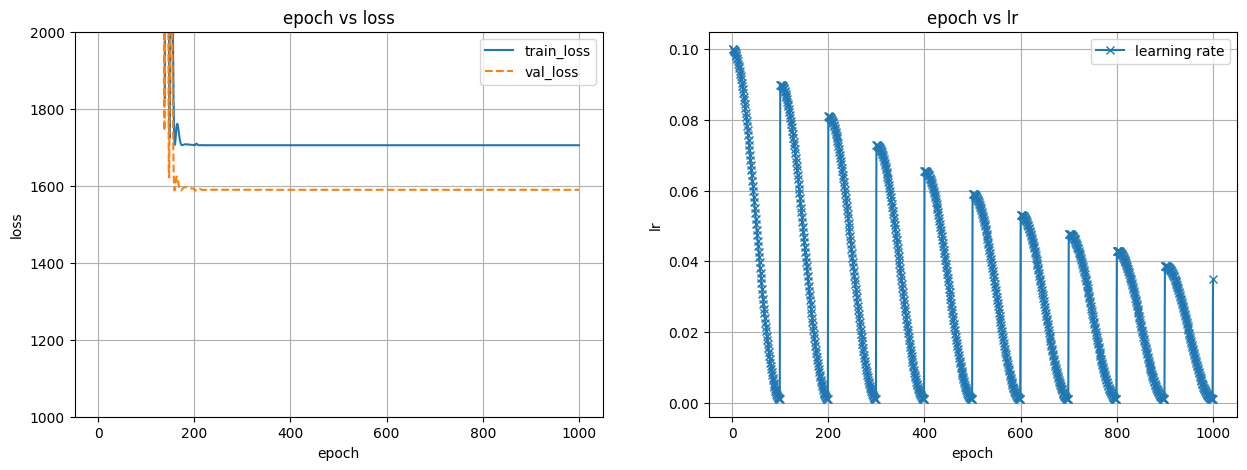

In [71]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim([1000, 2000])
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== lr Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_epoch, list_lr, marker='x', label='learning rate')
ax2.set_xlabel('epoch')
ax2.set_ylabel('lr')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs lr')

plt.show()

In [72]:
rep_train_loss = list_train_loss[-100:]
rep_val_loss = list_val_loss[-100:]
last_train_loss = sum(rep_train_loss)/len(rep_train_loss)
last_val_loss = sum(rep_val_loss)/len(rep_val_loss)

print(f"train loss: {last_train_loss}, val loss: {last_val_loss}")

train loss: 1705.1722192382813, val loss: 1589.352294921875
